1. IMPORTING LIBRARIES

In [2]:
# Importing libraries
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import *
from sklearn.metrics import *
from tensorflow.keras import *
from keras.models import load_model
from tensorflow.keras.utils import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# tf.config.set_visible_devices([], 'GPU')

2. LOADING THE DATA

In [3]:
# Loading Training Data
training_dir = 'Training/'
training_paths = []
train_labels = []

for label in os.listdir(training_dir):
    label_dir = os.path.join(training_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                training_paths.append(file_path)
                train_labels.append(label)

random.shuffle(training_paths)
random.shuffle(train_labels)

# show an example of the list
print(training_paths[0])

Training/pituitary/Tr-pi_0354.jpg


In [4]:
len(training_paths)

5712

In [5]:
# Loading Testing/Validation Data
test_dir = 'Testing/'
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    if os.path.isdir(label_dir):  # Check if it's a directory
        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)
            if not file.startswith('.'):  # Exclude hidden files
                test_paths.append(file_path)
                test_labels.append(label)

random.shuffle(test_paths)
random.shuffle(test_labels)

# show an example of the list
print(test_paths[0])

Testing/glioma/Te-gl_0277.jpg


In [6]:
len(test_paths)

1311

In [7]:
labels = [label for label in os.listdir(training_dir) if not label.startswith('.')]
labels

['pituitary', 'notumor', 'glioma', 'meningioma']

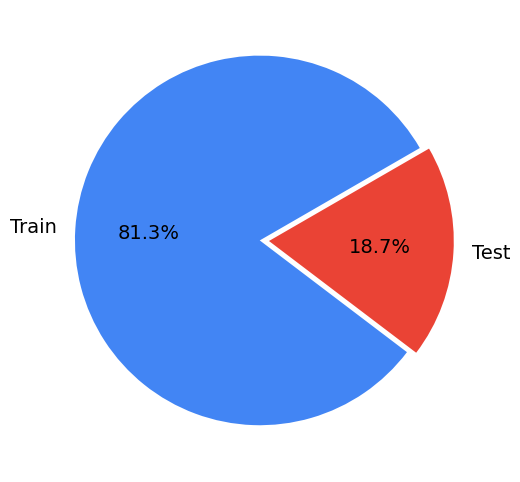

In [8]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

3. DATA AUGMENTATION

In [9]:
def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(256,256))
        image = image.convert('RGB')
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

def get_labels(paths):
    label = []
    for path in paths:
        path = path.split('/')[-2]
        label.append(labels.index(path))
    return label

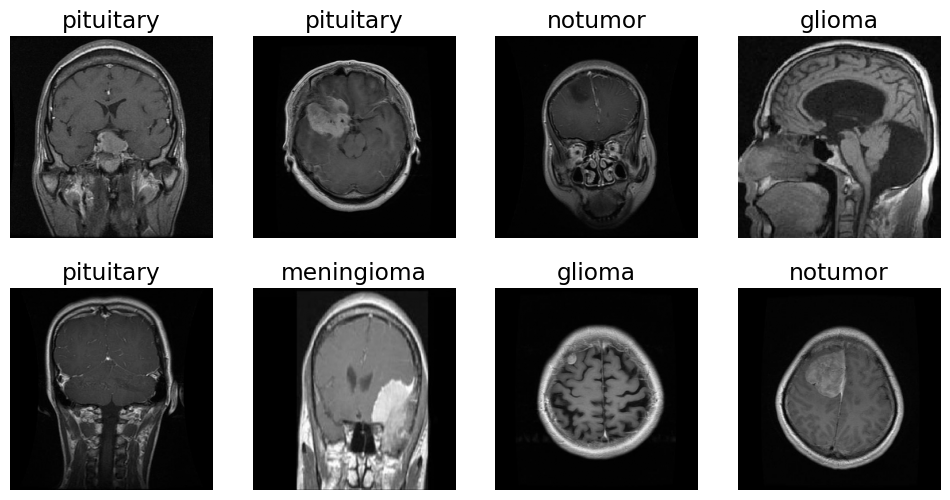

In [10]:
# i = random.randint(0,len(training_paths))
images = open_images(training_paths[50:59])
xlabels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(xlabels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 10})
plt.show()

4. DATA GENERATOR

In [11]:
# Expand the size of a training set by creating modified data from existing one
def data_gen(data_paths, batch_size=10):
    '''
    Given the image paths, it yields the images with the respective labels, as a batch
    '''
    for i in range(0, len(data_paths), batch_size):
        paths = data_paths[i:i+batch_size]
        images = open_images(paths)
        labels = get_labels(paths)
        yield images,np.array(labels)

5. BUILDING THE ResNet152V2 MODEL

In [12]:
# Loading the Pre-Trained Model (ResNet152V2)

base_model = ResNet152V2(input_shape = (256,256,3), 
                                                include_top = False, 
                                                weights = 'imagenet' )
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [13]:
len (base_model.layers)

564

In [14]:
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
    
# Set the last ResNet152V2 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [15]:
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax')) # num labels = 4

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 75,109,508
Trainable params: 17,832,580
No

In [16]:
len (model.layers)

6

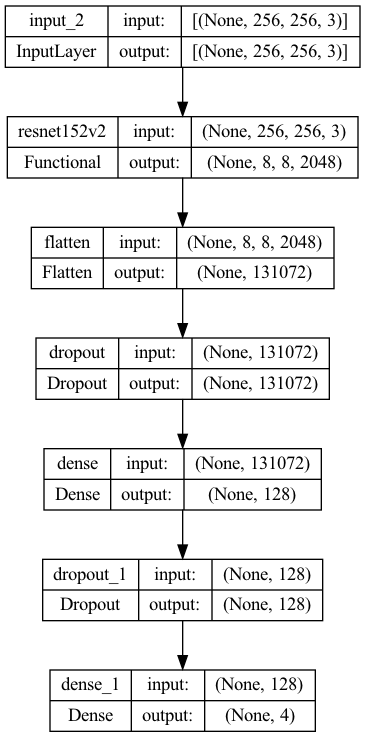

In [17]:
plot_model(model, show_shapes=True, to_file="resnet.png")

6. TRAINING THE MODEL

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001),
                                loss='sparse_categorical_crossentropy', 
                                metrics=['sparse_categorical_accuracy'])

In [19]:
# Training the Model

batch_size=256

history = model.fit(data_gen(training_paths), 
epochs=20,
steps_per_epoch=int(len(training_paths)/batch_size), 
validation_data= data_gen(test_paths),
validation_steps=int(len(test_paths)/batch_size)
 )

Epoch 1/20


2023-05-12 12:13:00.246617: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


22/22 [==============================] - 31s 1s/step - loss: 1.4364 - sparse_categorical_accuracy: 0.6091 - val_loss: 1.2157 - val_sparse_categorical_accuracy: 0.8000
Epoch 2/20
22/22 [==============================] - 26s 1s/step - loss: 1.1655 - sparse_categorical_accuracy: 0.7864 - val_loss: 0.2650 - val_sparse_categorical_accuracy: 0.8800
Epoch 3/20
22/22 [==============================] - 26s 1s/step - loss: 0.7665 - sparse_categorical_accuracy: 0.8182 - val_loss: 0.5709 - val_sparse_categorical_accuracy: 0.8400
Epoch 4/20
22/22 [==============================] - 26s 1s/step - loss: 0.6410 - sparse_categorical_accuracy: 0.8045 - val_loss: 0.6321 - val_sparse_categorical_accuracy: 0.8400
Epoch 5/20
22/22 [==============================] - 26s 1s/step - loss: 0.4533 - sparse_categorical_accuracy: 0.8636 - val_loss: 0.6802 - val_sparse_categorical_accuracy: 0.7800
Epoch 6/20
22/22 [==============================] - 26s 1s/step - loss: 0.3656 - sparse_categorical_accuracy: 0.8818 - va

In [20]:
model.save('resnet.h5')

7. EVALUATING THE MODEL

In [21]:
model = load_model ('resnet.h5')

In [22]:
evaluation = model.evaluate(data_gen(test_paths))

print('Test Loss:', evaluation[0])
print ('Test Accuracy:', evaluation[1])

132/132 [==============================] - 124s 929ms/step - loss: 0.2134 - sparse_categorical_accuracy: 0.9245
Test Loss: 0.2134147584438324
Test Accuracy: 0.9244851469993591


1/1 [==============================] - 0s 176ms/step
Predicted: notumor
Actual: notumor


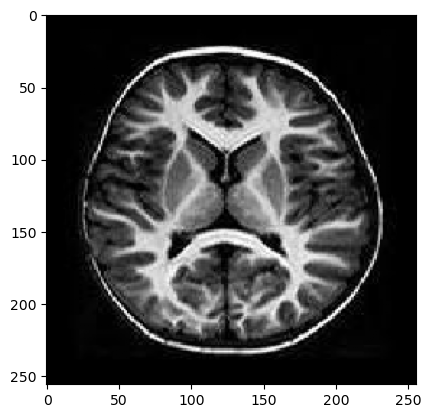

In [40]:
i = random.randint(0,len(test_paths))
images = open_images([test_paths[i]])
predicted = model.predict(images)[0]
predicted = np.argmax(predicted)
predicted = labels[predicted]
label = test_paths[i].split('/')[-2]
plt.imshow(images[0])
print('Predicted:', predicted)
print('Actual:', label)

In [41]:
print(history.history.keys())

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


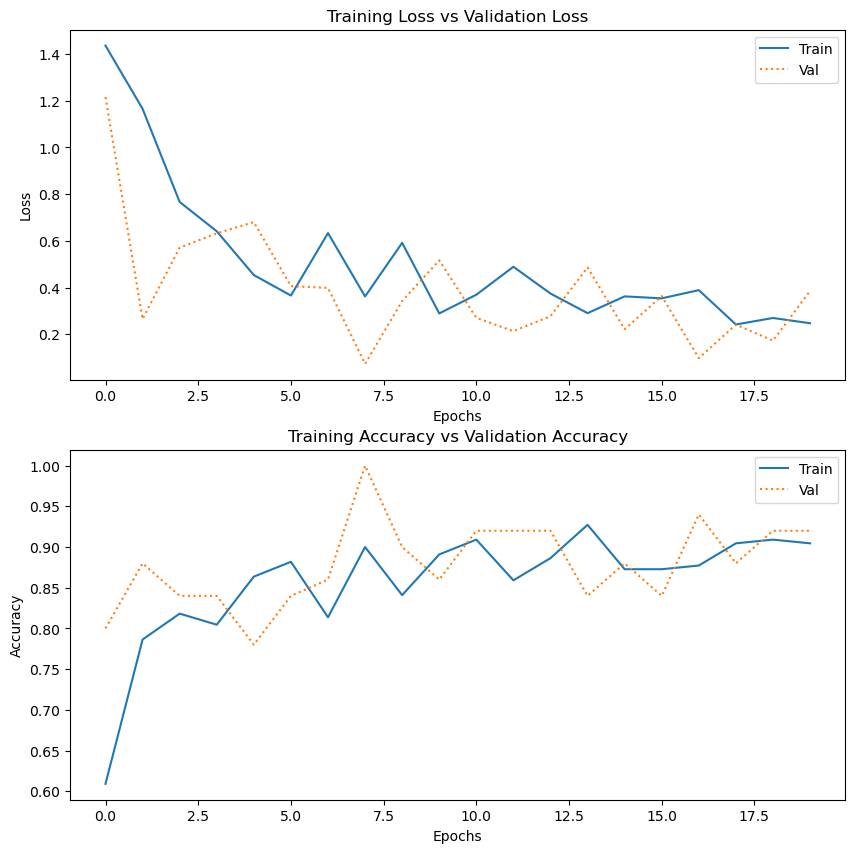

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'], linestyle='dotted')
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['sparse_categorical_accuracy'])
axs[1].plot(history.history['val_sparse_categorical_accuracy'], linestyle='dotted')
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

8. CLASSIFICATION REPORT AND CONFUSION MATRIX

In [43]:
# For Classification Report

test_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_generator.flow_from_directory(test_dir, target_size=(256,256), shuffle=False, seed=21,
                                                     class_mode='sparse', batch_size=16)

Found 1311 images belonging to 4 classes.


In [44]:
classes = labels
#On test dataset
Y_pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
target_names = classes

82/82 [==============================] - 119s 1s/step


In [45]:
#Classification Report

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   pituitary       0.01      0.01      0.01       300
     notumor       0.02      0.03      0.02       306
      glioma       0.01      0.00      0.01       405
  meningioma       0.02      0.02      0.02       300

    accuracy                           0.02      1311
   macro avg       0.02      0.02      0.02      1311
weighted avg       0.01      0.02      0.02      1311



In [47]:
# For Confusion Matrix
target_labels = ["glioma", "meningioma", "notumor", "pituitary"]

Generator = ImageDataGenerator(rescale=1./255)
test_gen = Generator.flow_from_directory(test_dir,
                                        # resizing testing images to (min(heights), min(widths)) in both trainining and testing sets
                                          target_size = (256,256),
                                          color_mode = 'rgb',
                                          classes = target_labels,
                                          class_mode = 'sparse',
                                          batch_size = 16,
                                          shuffle = False,
                                         )

Found 1311 images belonging to 4 classes.


In [48]:
def test_model(model, test_generator):
    y_pred = model.predict(x = test_generator, verbose = 1)
    print(y_pred.shape)
    print(y_pred[:10])
    return y_pred

In [49]:
y_pred = test_model(model, test_gen)
print(y_pred[:10])

82/82 [==============================] - 115s 1s/step
(1311, 4)
[[1.7827116e-07 3.5553967e-06 9.9563968e-01 4.3566395e-03]
 [2.9483706e-05 3.7356585e-05 8.4434837e-01 1.5558472e-01]
 [1.1393289e-07 1.8970064e-06 9.9669659e-01 3.3013483e-03]
 [3.2477896e-05 9.1880747e-06 5.3127207e-02 9.4683117e-01]
 [1.2880769e-02 7.9477287e-04 6.0709715e-01 3.7922725e-01]
 [2.7459396e-07 4.5938497e-05 9.9932575e-01 6.2804768e-04]
 [2.3294972e-07 8.3521172e-08 9.9941134e-01 5.8832287e-04]
 [2.6004872e-07 1.7814959e-07 9.9999285e-01 6.6379966e-06]
 [2.5356756e-04 2.6339671e-07 9.9792337e-01 1.8227646e-03]
 [3.0667425e-06 9.0051599e-06 9.8960131e-01 1.0386680e-02]]
[[1.7827116e-07 3.5553967e-06 9.9563968e-01 4.3566395e-03]
 [2.9483706e-05 3.7356585e-05 8.4434837e-01 1.5558472e-01]
 [1.1393289e-07 1.8970064e-06 9.9669659e-01 3.3013483e-03]
 [3.2477896e-05 9.1880747e-06 5.3127207e-02 9.4683117e-01]
 [1.2880769e-02 7.9477287e-04 6.0709715e-01 3.7922725e-01]
 [2.7459396e-07 4.5938497e-05 9.9932575e-01 6.2804

In [50]:
Y_pred = (y_pred > 0.5).astype(int)
print(Y_pred[:10])

[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]


In [51]:
print(test_gen.labels[:10])

[0 0 0 0 0 0 0 0 0 0]


In [52]:
labelBinarizer = LabelBinarizer()
test_labels = labelBinarizer.fit_transform(test_gen.labels)
print(test_labels[:10])

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [53]:
def plot_cf_matrix(confusion_matrix, axes, class_label, class_names, fontsize = 10):
    df_cm = pd.DataFrame(confusion_matrix, index = class_names, columns = class_names,)

    try:
        heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cbar = False, ax = axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right', fontsize = fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation = 45, ha = 'right', fontsize = fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("class : " + class_label)

In [54]:
def plot_confusion_matrices(conf_matrices, target_labels):
    fig, ax = plt.subplots(1, len(target_labels), figsize = (15, 5))

    for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrices, target_labels):
        plot_cf_matrix(cfs_matrix, axes, label, ["POSITIVE", "NEGATIVE" ])

    fig.tight_layout()
    plt.show()

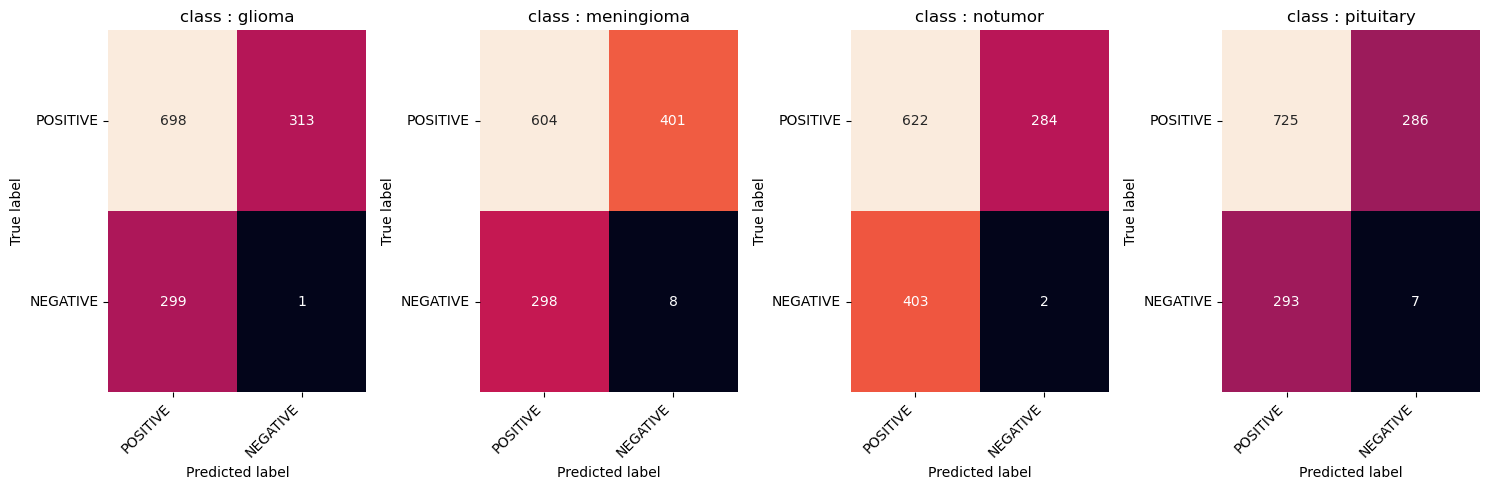

In [55]:
# Confusion Matrix for each class

conf_matrices = multilabel_confusion_matrix(y_true = test_labels, y_pred = Y_pred, labels = [0, 1, 2, 3])
plot_confusion_matrices(conf_matrices, target_labels)